In [1]:
import sys
sys.path = [p for p in sys.path if "ParaView" not in p]


import bisect
import torch as pt
import matplotlib.pyplot as plt
import matplotlib as mpl
from flowtorch import DATASETS
from flowtorch.data import FOAMDataloader, mask_box
from flowtorch.analysis import SVD

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


In [2]:

# Load and Prepare Data
from pathlib import Path

# Load the dataset
path = str(Path("~/OpenFOAM/run/cylinder_2D_Re800").expanduser())
loader = FOAMDataloader(path)
times = loader.write_times
fields = loader.field_names
print(f"Number of available snapshots: {len(times)}")
print("First five write times: ", times[:5])
print(f"Fields available at t={times[-1]}: ", fields[times[-1]])



Number of available snapshots: 10001
First five write times:  ['0', '0.002', '0.004', '0.006', '0.008']
Fields available at t=20:  ['p', 'U']


In [3]:
# load vertices and discard z-coordinate
vertices = loader.vertices[:, :2]
mask = mask_box(vertices, lower=[0.1, -1], upper=[0.75, 1])

INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor0/constant
INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor1/constant


In [4]:
print(f"Selected vertices: {mask.sum().item()}/{mask.shape[0]}")

Selected vertices: 5746/9800


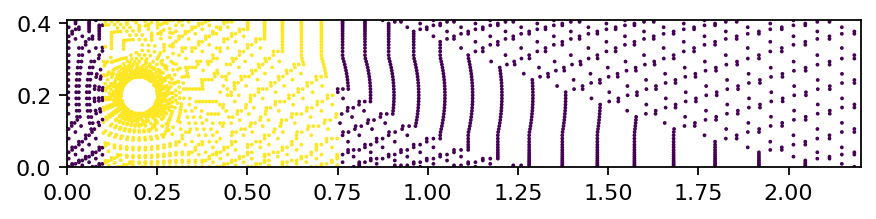

In [5]:
every = 4 # use only every 4th vertex
fig, ax = plt.subplots()
ax.scatter(vertices[::every, 0], vertices[::every, 1], s=0.5, c=mask[::every])
ax.set_aspect("equal", 'box')
ax.set_xlim(0.0, 2.2)
ax.set_ylim(0.0, 0.41)
plt.show()

In [6]:
window_times = [time for time in times if float(time) >= 4.0]
data_matrix = pt.zeros((mask.sum().item(), len(window_times)), dtype=pt.float64)
for i, time in enumerate(window_times):
    # load the velocity field
    velocity = loader.load_snapshot("U", time)
    data_matrix[:, i] = pt.masked_select(velocity[:, 0], mask)  # x-component


# subtract the temporal mean
data_matrix -= pt.mean(data_matrix, dim=1).unsqueeze(-1)

In [7]:
# Singular Value Decomposition

svd = SVD(data_matrix, rank=400)
svd_recon = (svd.U @ pt.diag(svd.s) @ svd.V.T).numpy()

print(svd)

SVD of a 5746x8001 data matrix
Selected/optimal rank: 400/1788
data type: torch.float64 (8b)
truncated SVD size: 41.9556Mb


In [8]:
# Singular Values

s = svd.s
s_sum = s.sum().item()
# relative contribution
s_rel = [s_i / s_sum * 100 for s_i in s]
# cumulative contribution
s_cum = [s[:n].sum().item() / s_sum * 100 for n in range(s.shape[0])]
# find out how many singular values we need to reach at least 99 percent
i_99 = bisect.bisect_right(s_cum, 99)

# Use the first i_99 singular values for reconstruction
U_r = svd.U[:, :i_99]
S_r = pt.diag(svd.s[:i_99])
V_r = svd.V[:, :i_99]
svd_recon = (U_r @ S_r @ V_r.T).numpy()



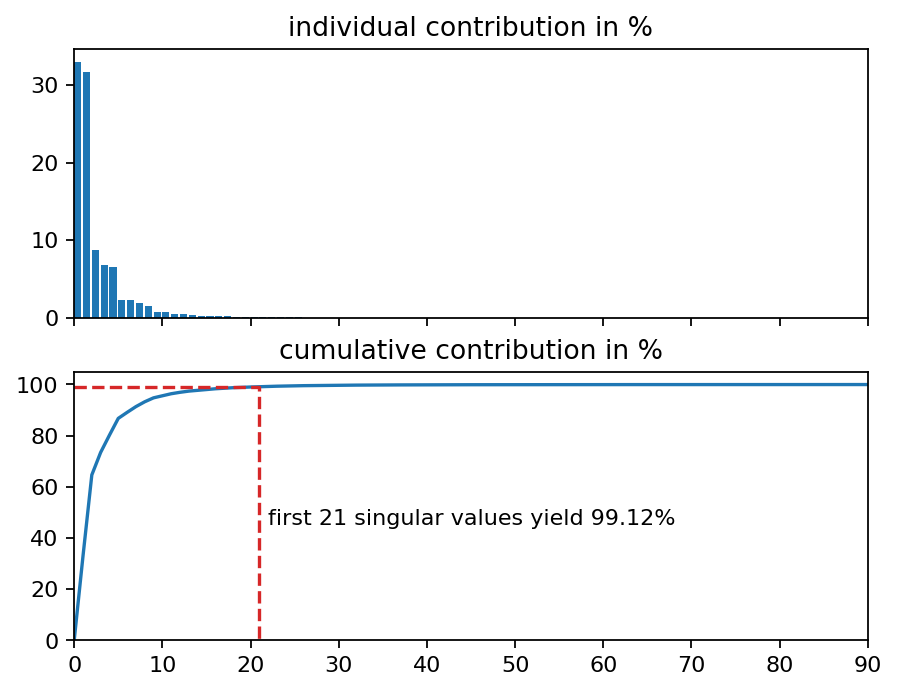

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.bar(range(s.shape[0]), s_rel, align="edge")
ax2.plot(range(s.shape[0]), s_cum)
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 105)
ax1.set_title("individual contribution in %")
ax2.set_title("cumulative contribution in %")
ax2.plot([0, i_99, i_99], [s_cum[i_99], s_cum[i_99], 0], ls="--", color="C3")
ax2.text(i_99+1, 45, "first {:d} singular values yield {:1.2f}%".format(i_99, s_cum[i_99]))
plt.show()

# Left Singular Vectors

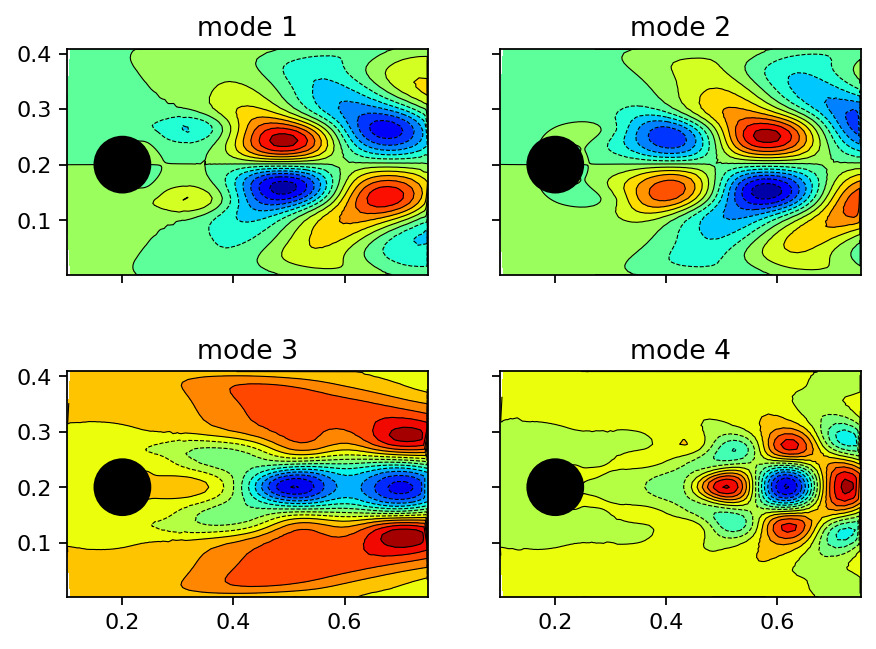

In [10]:
x = pt.masked_select(vertices[:, 0], mask).numpy()
y = pt.masked_select(vertices[:, 1], mask).numpy()

fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
count = 0
for row in range(2):
    for col in range(2):
        axarr[row, col].tricontourf(x, y, svd.U[:, count], levels=14, cmap="jet")
        axarr[row, col].tricontour(x, y, svd.U[:, count], levels=14, linewidths=0.5, colors='k')
        axarr[row, col].add_patch(plt.Circle((0.2, 0.2), 0.05, color='k'))
        axarr[row, col].set_aspect("equal", 'box')
        # add 1 for the POD mode number since we subtracted the mean
        axarr[row, col].set_title(f"mode {count + 1}")
        count += 1
plt.show()



# Right Singular Vectors

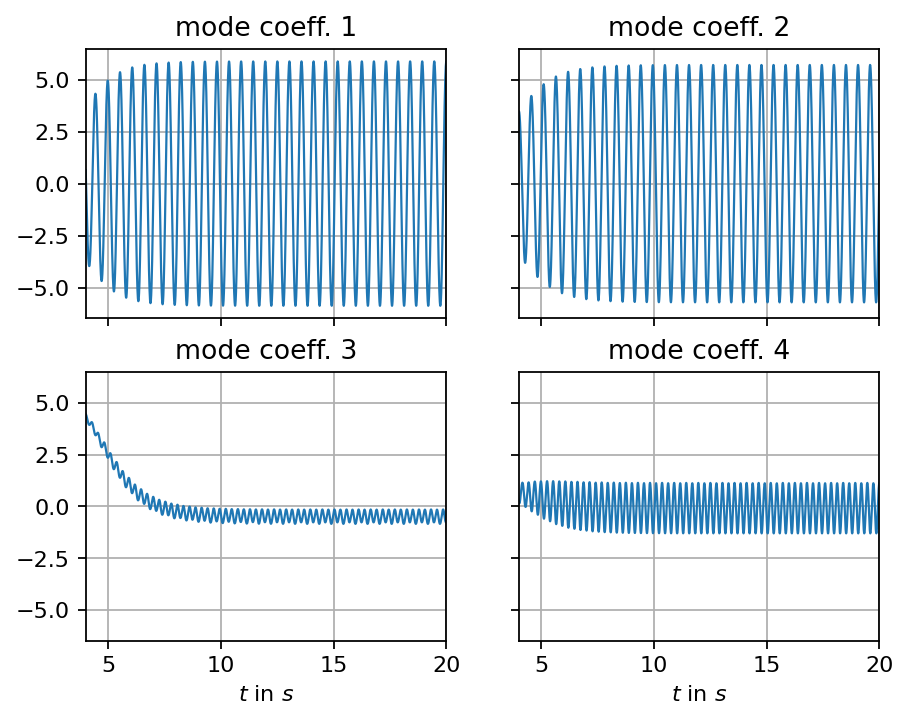

In [11]:
times_num = [float(time) for time in window_times]

fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
count = 0
for row in range(2):
    for col in range(2):
        axarr[row, col].plot(times_num, svd.V[:, count]*svd.s[count], lw=1, label=f"coeff. mode {i+1}")
        axarr[row, col].set_xlim(min(times_num), max(times_num))
        axarr[row, col].grid()
        # add 1 for the POD mode number since we subtracted the mean
        axarr[row, col].set_title(f"mode coeff. {count + 1}")
        count += 1
for ax in axarr[1, :]:
    ax.set_xlabel(r"$t$ in $s$")
plt.show()

